# EMERGENCY CALLS TO THE SAN FRANCISCO FIRE DEPARTMENT

 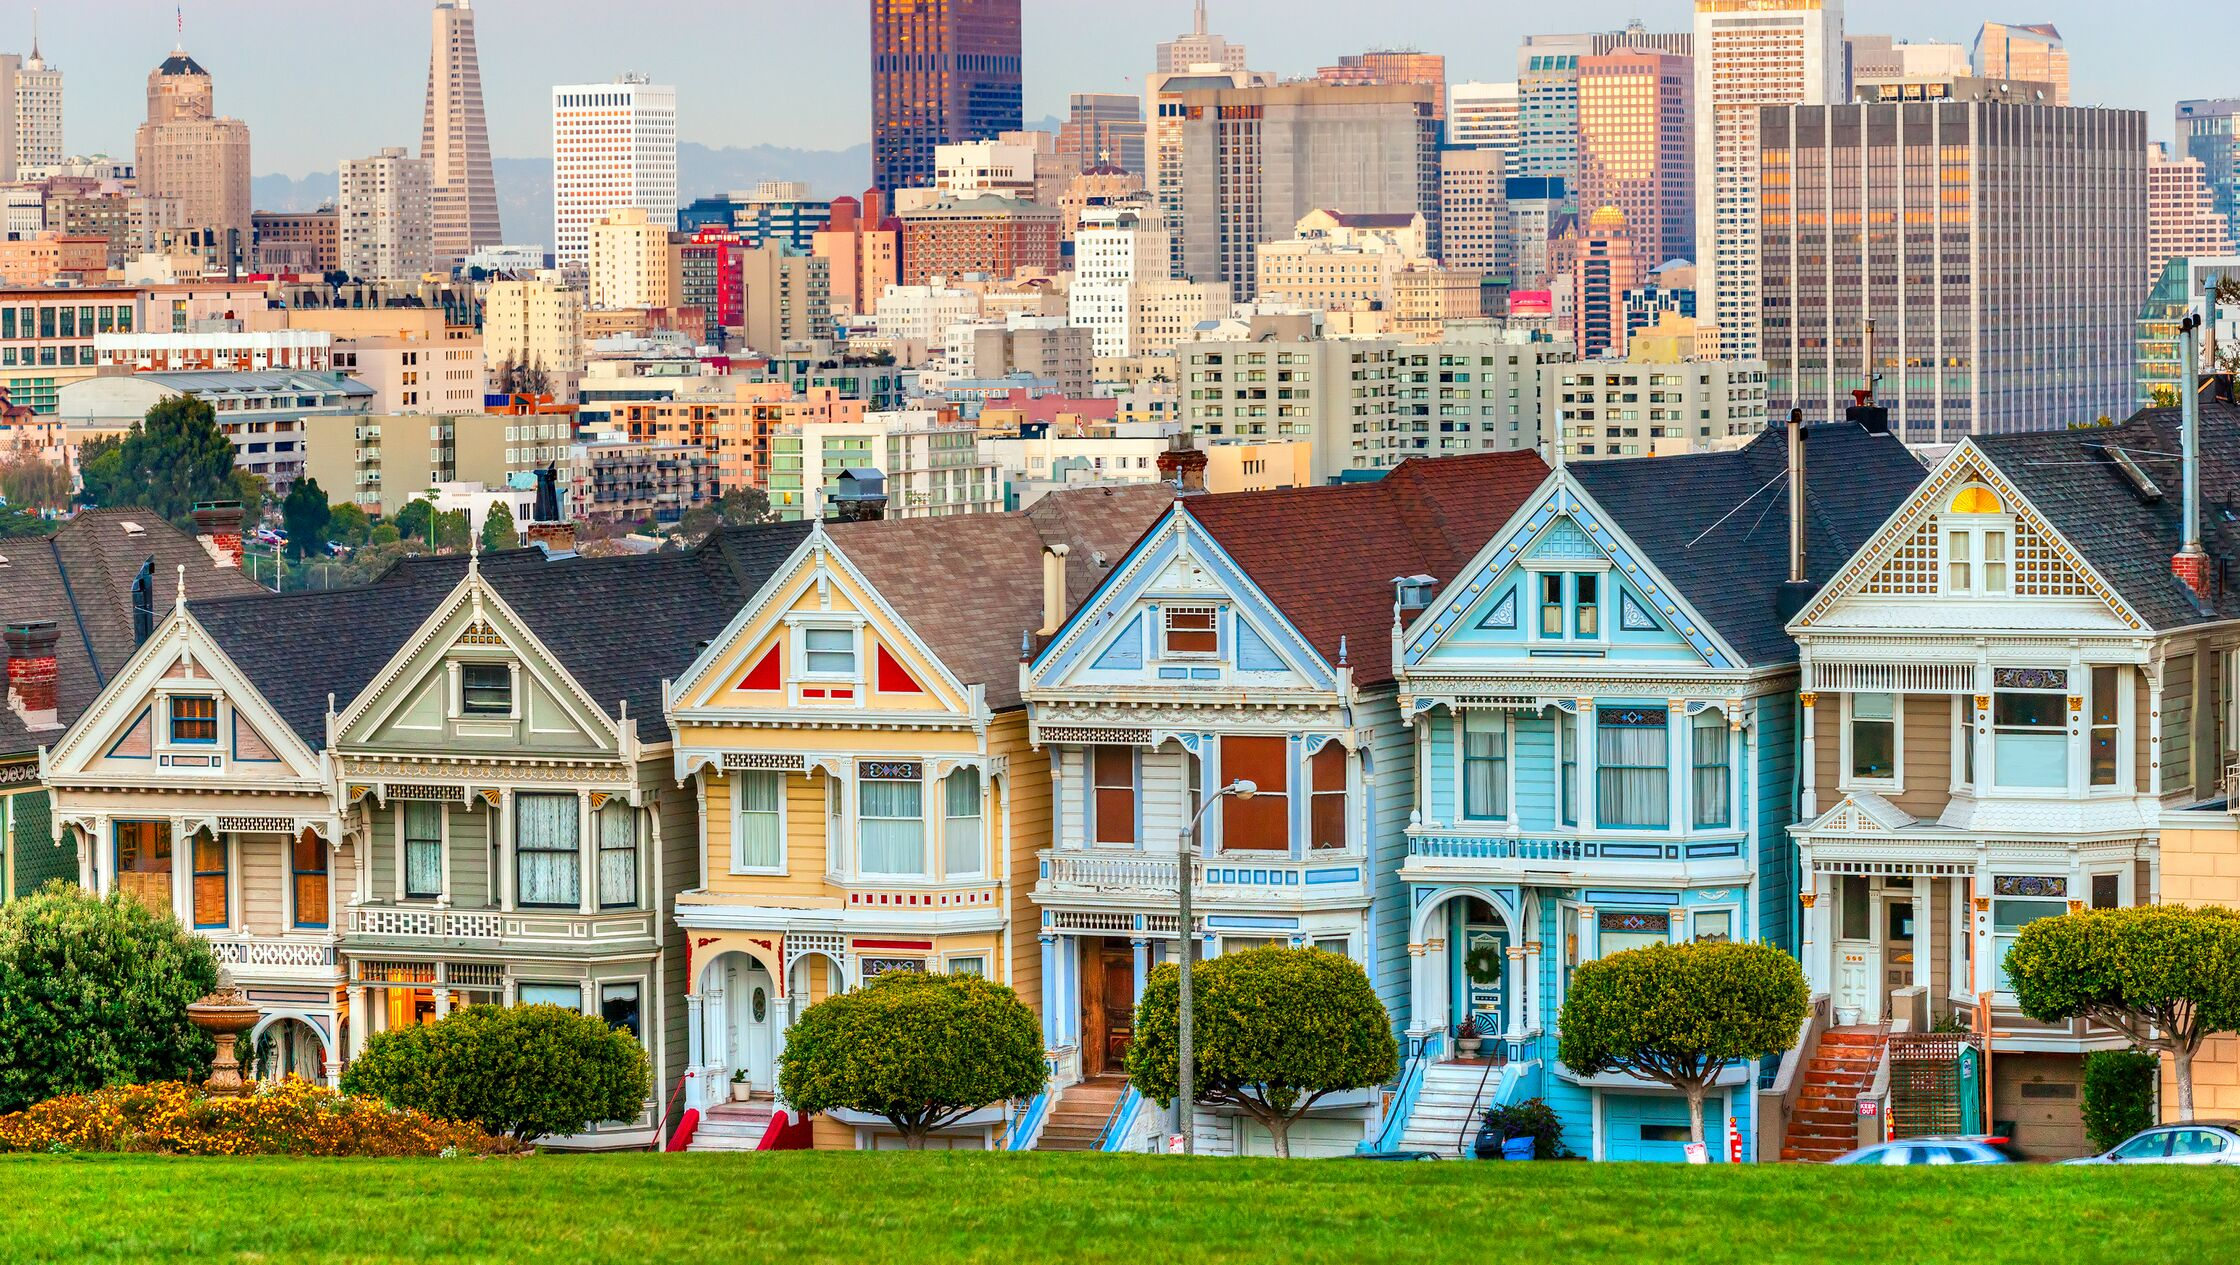

# I. Introduction

In 2022, the San Francisco Fire Department *(SFFD)* responded to over 150,000 emergency calls, encompassing a wide range of incidents from structure fires to medical emergencies and water rescues. Each of these situations began with a critical *9-1-1* call, during which operators gathered essential details about the nature of the emergency and its location. While operators provide instructions and vital information, one key piece of information is not given: the exact time it will take for the SFFD to arrive on scene. Currently, individuals are only told that the emergency services are on there way. Understanding the SFFD's response time can be crucial, as it aids in strategizing building evacuations, implementing immediate medical treatments, and so on. Therefore, for our final project, we will be analyzing all the emergency calls made to the Fire Department of San Francisco in 2022 and try to develop a predictive model for the SFFD's **response time**.

Before we begin predicting the SFPD's **response time**, we will clean the data, add additional features, and try to get an understanding of the data, including how the variables in the dataset relate to the **response time**. This will allow us to identify which features are most relevant for predictive model.

In [1]:
# Relevant packages
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim, GoogleV3
from geopy.distance import geodesic
import re
import osmnx as ox
from concurrent.futures import ThreadPoolExecutor
import time
from IPython.display import display, Image, HTML
from ipywidgets import interact, Dropdown

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier


import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_columns', None)

## Getting, Cleaning & Preparing the Data


The original dataset *(obtained from data.gov)* consists of more than 20 years worth of calls to the fire department, resulting in a csv-file with a whopping filesize of 2.6GB. As this is way to big for the analysis we want to perform, we decided to stick with the data of just one year, 2022. So, to get rid of the other ~19 years we first utilized Stata before loading it into jupyter. Stata is a very efficient programme that allows us to manipulate the data easily and quickly.

In [ ]:
# this code was ran in STATA
import delimited "Fire_Department_Calls_for_Service.csv"

gen calldate_formatted = date(calldate, "MDY") #generating a date variable that can be easily sorted

sort calldate_formatted

drop if calldate_formatted < 22646 #drop date's before 01-01-2022

drop if calldate_formatted > 23010 #drop date's after 31-12-2022

export delimited using "/fire_department_calls_2022.csv", replace


In [ ]:
# JUPYTER
df_1 = pd.read_csv('/Users/timvanvliet/Documents/LSE/ST445/Final project/fire_department_calls_2022.csv', sep=',')
# this file is still over 100MB and, hence, not committed to GitHub

In [9]:
df = df_1.copy()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333517 entries, 0 to 333516
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   callnumber                        333517 non-null  int64  
 1   unitid                            333517 non-null  object 
 2   incidentnumber                    333517 non-null  int64  
 3   calltype                          333517 non-null  object 
 4   calldate                          333517 non-null  object 
 5   watchdate                         333517 non-null  object 
 6   receiveddttm                      333517 non-null  object 
 7   entrydttm                         333517 non-null  object 
 8   dispatchdttm                      333517 non-null  object 
 9   responsedttm                      325751 non-null  object 
 10  onscenedttm                       265671 non-null  object 
 11  transportdttm                     81880 non-null   o

After having loaded our dataset onto Jupyter, we can see that there is still a lot of data left, 333.517 entries to be precise. This dataset is, however, based on total responses to the emergencies. Meaning that, if multiple units answered the call than they all have a seperate entry in the dataset *(they do have the same 'callnumber')*. We will deal with this later... Additionally, the dataset is made out of variables that the describe the location of the incident *(e.g, 'zipcode'; 'case_location', longitude and latitude information; 'city')*, variables that contain information on the fire department *(e.g., 'unittype', the unit that responded; 'stationarea')*, and variables that have information on the incident *(e.g., 'originalpriority'; 'calltype', the kind of emergency; 'calltypegroup', non or life threatening)*.

Furthermore, you can see that our variable of interest, **response time**, is not in the dataset. We'll have to create it ourself. To do that we'll be using the respons time as defined by the County of San Francisco; the difference in time between the call being entered into the system *(entrydttm)* and arriving at the scene *(onscenedttm)*. We will also be creating additional features from the time of the call *(i.e., day of the week, month, hour)*.

Moreover, the dataset contains information that would not be available at the time of the call *(i.e., final priority, time of dispatch, arrival at the scene, etc)*. These columns will be removed.

After performing the code below there are 260.134 observations remaining.

Source (response time SF): https://sfgov.org/scorecards/public-safety/police-response-serious-incidents

In [34]:
# renaming columns for simplicity
df = df.rename(columns={'neighborhooodsanalysisboundaries': 'neighborhood'})
df = df.rename(columns={'zipcodeofincident': 'zip'})

# extracting the hour/weekday/month of the emergency and put it in separate columns
df['entrydttm'] = pd.to_datetime(df['entrydttm'])
df['receiveddttm'] = pd.to_datetime(df['receiveddttm']) #just for formatting
df['hour_of_the_day'] = df['entrydttm'].dt.hour
df['day_of_week'] = df['entrydttm'].dt.dayofweek
df['month'] = df['entrydttm'].dt.month

# determining response time
df['onscenedttm'] = pd.to_datetime(df['onscenedttm'])
df['respond_time'] = df['onscenedttm'] - df['entrydttm']
df['respond_time'] = pd.to_timedelta(df['respond_time'])
df['respond_time'] = df['respond_time'].dt.total_seconds() # Convert timedelta to seconds
df = df[df['respond_time'] > 0] #there are some error's in the data, resulting in a negative response time, they are removed

# extracting the latitude and longitude of the case locations
df[['case_longitude', 'case_latitude']] = df['case_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
df['case_longitude'] = df['case_longitude'].astype(float)
df['case_latitude'] = df['case_latitude'].astype(float)

# converting columns with Dtype: Object, that should in fact be fully numeric
df['firepreventiondistrict'].replace('None', 11, inplace=True) # firepreventiondistrict 'None' = 11
df['supervisordistrict'].replace('None', 12, inplace=True) #supervisordistrict 'None' = 12
df['firepreventiondistrict'] = pd.to_numeric(df['firepreventiondistrict'])
df['supervisordistrict'] = pd.to_numeric(df['supervisordistrict'])

# deleting columns containing information not present at the time of the 9-1-1 call
columns_to_remove = ['dispatchdttm', 'responsedttm', 'onscenedttm','callfinaldisposition', 'priority', 'finalpriority',]
df = df.drop(columns=columns_to_remove, axis=1)

# deleting columns without any explanatory information
unimportant_columns =['incidentnumber','watchdate','transportdttm','hospitaldttm','availabledttm','rowid','data_loaded_at','calldate_formatted']
df = df.drop(columns=unimportant_columns, axis=1)

# As there are a lot of observations and not many NaN's in the dataset (after dropping the previous columns); we simply drop them.
df = df.dropna()

df.head(3)

callnumber unitid           calltype    calldate        receiveddttm  \
0   220012327  EMS6B   Medical Incident  01/01/2022 2022-01-01 16:07:22   
2   220012550     54   Medical Incident  01/01/2022 2022-01-01 17:26:02   
3   220010525    E35  Traffic Collision  01/01/2022 2022-01-01 02:19:40   

            entrydttm                   address           city      zip  \
0 2022-01-01 16:08:29     100 Block of BAKER ST  San Francisco  94117.0   
2 2022-01-01 17:26:29  2200 Block of MISSION ST  San Francisco  94110.0   
3 2022-01-01 02:19:40           4TH ST/BERRY ST  San Francisco  94158.0   

  battalion  stationarea   box originalpriority  alsunit  \
0       B05         21.0  4251                3    False   
2       B02          7.0  5423                3     True   
3       B03          8.0  2225                A     True   

                  calltypegroup  numberofalarms unittype  \
0          Non Life-threatening               1    CHIEF   
2  Potentially Life-Threatening               1    MEDIC   
3  Potentially Life-Threatening               1   ENGINE   

   unitsequenceincalldispatch  firepreventiondistrict  supervisordistrict  \
0                           4                     5.0                   5   
2                           2                     6.0                   9   
3                           6                     3.0                   6   

     neighborhood                                  case_location  \
0  Haight Ashbury  POINT (-122.44070899863335 37.77223727448809)   
2         Mission  POINT (-122.41935164261461 37.76103144298335)   
3     Mission Bay   POINT (-122.3933551263987 37.77578731465375)   

   analysisneighborhoods  hour_of_the_day  day_of_week  month  respond_time  \
0                    3.0               16            5      1        5202.0   
2                   20.0               17            5      1         807.0   
3                    4.0                2            5      1         465.0   

   case_longitude  case_latitude  
0     -122.440709      37.772237  
2     -122.419352      37.761031  
3     -122.393355      37.775787

Furthermore, it will be usefull for our analysis to also get the locations of all the 44 firestations in San Francisco. To get the longitude and latitude information we used webscraping and the Geocoding API.

In [120]:
url = 'https://sf-fire.org/fire-stations'

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')
table_rows = soup.find_all('tr')

names = []
addresses = []

for row in table_rows:
    # finding the cells containing station name and address
    cells = row.find_all('td', class_=lambda x: x in ['views-field-name', 'views-field-field-address'])
    if len(cells) == 2:
        names.append(cells[0].get_text(strip=True))
        address_parts = cells[1].find_all('span', class_=lambda x: x in ['address-line1', 'locality', 'administrative-area', 'postal-code'])
        address = ' '.join(part.get_text(strip=True) for part in address_parts)
        addresses.append(address)

data = {'Firestations': names, 'Address': addresses}
firestation_info = pd.DataFrame(data)

# there are 4 firestation in the table that don't have an adress, so we add those manually
firestation_info.loc[firestation_info['Firestations'] == 'San Francisco Fire Station 25', 'Address'] = '3305 3rd St San Francisco CA 94124'
firestation_info.loc[firestation_info['Firestations'] == 'San Francisco Fire Station 34', 'Address'] = '499 41st Ave San Francisco CA 94121'
firestation_info.loc[firestation_info['Firestations'] == 'San Francisco Fire Station 43', 'Address'] = '720 Moscow St San Francisco CA 94112'
firestation_info.loc[firestation_info['Firestations'] == 'San Francisco Fire Station 48', 'Address'] = '800 Ave I San Francisco CA 94130'

# moreover, there are three fire departments located at the airport which are not in the sample; they are removed.
firestation_info = firestation_info[firestation_info['Address'] != '']


latitudes = []
longitudes = []

geolocator = Nominatim(user_agent="AIzaSyCY0a70GFCbEtTIfOaoOolg5kDxKOy4B",timeout=10) #using GeoCode API

# geocode each address and retrieve latitude and longitude
for row in firestation_info['Address']:
    location = geolocator.geocode(row)
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
    else:
        latitudes.append(None)
        longitudes.append(None)

# add latitude and longitude columns to firestation_info
firestation_info['FS_latitude'] = latitudes
firestation_info['FS_longitude'] = longitudes
firestation_info['FS_latitude'] = firestation_info['FS_latitude'].astype(float)
firestation_info['FS_longitude'] = firestation_info['FS_longitude'].astype(float)


print(firestation_info.head())

firestation_info.to_csv('Firestation_info.csv')


Firestations                                    Address  \
0   San Francisco Fire Station 1   935 Folsom Street San Francisco CA 94103   
1   San Francisco Fire Station 2  1340 Powell Street San Francisco CA 94133   
2   San Francisco Fire Station 3    1067 Post Street San Francisco CA 94109   
3  San Francisco Fire Station 10       655 Presidio Avenue San Francisco CA   
4  San Francisco Fire Station 11          3880 26th Street San Francisco CA   

   FS_latitude  FS_longitude  
0    37.779417   -122.404100  
1    37.797018   -122.409903  
2    37.786822   -122.419317  
3    37.785610   -122.446821  
4    37.748677   -122.426505

Additionally, the regular driving time and distance between the firestation and the scene could be important indicators on how quick the fire department will be able to respond. Information that will also be at hand when someone in distress places a call, as they provide their location to the operator. 

At first, we were able to determine the time and distance based on historical traffic data using the Google Maps Distance Matrix API. However, after reaching the free budget of €50 fairly quickly *(just too many observations)*, we decided it wouldn't be worth it... Instead we utilized the Open Source Routing Maching *(OSRM)* API to determine the driving distance and driving time *(it took 2 days to run)*. The driving time obtained reflects an estimate based on factors such as road types, speed limits, and historical traffic patterns.

In [ ]:
# getting rid of the 'San Francisco Fire Station' to be able to merge firestation_info with df
firestation_info_copy = firestation_info.copy()
firestation_info_copy['Firestations'] = firestation_info_copy['Firestations'].str.replace('San Francisco Fire Station ','').str.strip()
firestation_info_copy['Firestations'] = firestation_info_copy['Firestations'].astype(int)

firestation_info_copy = firestation_info_copy.rename(columns={'Firestations':'stationarea'}) #for merging purposes

# merging firestation_info with df
df = df.merge(firestation_info_copy[['FS_latitude','FS_longitude','stationarea']], on='stationarea', how='left')
df.head()

def distance_time(row):
    scene = (row['case_latitude'], row['case_longitude'])
    firestation = (row['FS_latitude'], row['FS_longitude'])

    # a request to OSM's API
    url = f"http://router.project-osrm.org/route/v1/driving/{firestation[1]},{firestation[0]};{scene[1]},{scene[0]}?overview=false"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        driving_distance = data['routes'][0]['distance']  # Distance in meters
        duration = data['routes'][0]['duration']  # Duration in seconds
        
        return driving_distance, duration
    else:
        # if request fails, return None for distance and duration
        return None, None

# applying the function to DataFrame rows
df[['driving_distance', 'travel_time']] = df.apply(distance_time, axis=1, result_type='expand')

As previously mentioned, this dataset is based on responses, and since most emergency calls involve multiple units that respond, there exist multiple records for each call. Consequently, if a duplicate call number is identified, we kept the one with the shortest response time. This will of course be the best representation of the response time. This final bit of cleaning (for now), results in a dataset containing 152.384 emergencies *(=rows)*.

In [14]:
df = df.sort_values(by='respond_time')
df = df.drop_duplicates(subset='callnumber', keep='first') # keeping only the quickest response time per emergency
df = df.reset_index(drop=True)

df = df.sort_values(by='receiveddttm') #sort again by date, because why not

df.to_csv('fire_department_calls_2022_fully_complete.csv') #saving the file, as we don't want to run the previous code again...

df.head(3)

callnumber unitid          calltype    calldate         receiveddttm  \
0   220010001     66  Medical Incident  01/01/2022  2022-01-01 00:00:18   
1   220010017  KM104  Medical Incident  01/01/2022  2022-01-01 00:00:41   
2   220010013    E01  Medical Incident  01/01/2022  2022-01-01 00:00:52   

             entrydttm callfinaldisposition                      address  \
0  2022-01-01 00:00:18     Code 2 Transport  300 Block of BAY SHORE BLVD   
1  2022-01-01 00:03:45     Code 2 Transport        400 Block of 22ND AVE   
2  2022-01-01 00:02:16     Unable to Locate          100 Block of 6TH ST   

            city      zip battalion  stationarea     box originalpriority  \
0  San Francisco  94124.0       B10         42.0  6374.0                A   
1  San Francisco  94121.0       B07         14.0  7172.0                2   
2  San Francisco  94103.0       B03          1.0  2251.0                3   

   alsunit                 calltypegroup  numberofalarms unittype  \
0     True          Non Life-threatening               1    MEDIC   
1    False          Non Life-threatening               1  PRIVATE   
2     True  Potentially Life-Threatening               1   ENGINE   

   unitsequenceincalldispatch  firepreventiondistrict  supervisordistrict  \
0                           1                    10.0                  10   
1                           1                     7.0                   1   
2                           1                     3.0                   6   

            neighborhood                                   case_location  \
0  Bayview Hunters Point   POINT (-122.40647997586389 37.74105755281323)   
1         Outer Richmond    POINT (-122.4813790851859 37.77927170419218)   
2        South of Market  POINT (-122.40846655617251 37.780700831878036)   

   analysisneighborhoods  hour_of_the_day  day_of_week  month  respond_time  \
0                    1.0                0            5      1         558.0   
1                   29.0                0            5      1         802.0   
2                   34.0                0            5      1         283.0   

   case_longitude  case_latitude  fs_latitude  fs_longitude  driving_distance  \
0     -122.406480      37.741058    37.731583    -122.40556        1198.00000   
1     -122.481379      37.779272    37.779007    -122.48586         587.79999   
2     -122.408467      37.780701    37.779415    -122.40410         608.79999   

   travel_time  
0        120.0  
1         86.6  
2         82.4

Laslty, we will be visualizing the city of San Francisco, so we downloaded the zipcode geometry information.

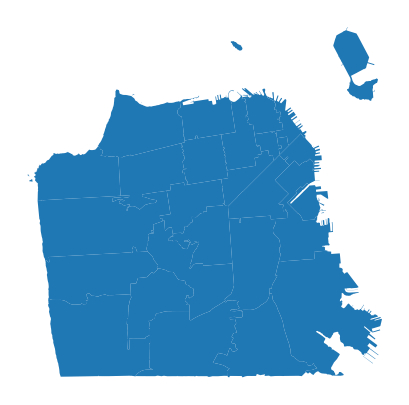

In [18]:
#Downloaded from data.sfgov.org
sf_map = gpd.read_file('San Francisco ZIP Codes/geo_export_d7d63dbd-dcec-4b62-93ba-ca2ca32b9bd9.shp')
fig, ax = plt.subplots(figsize=(7, 5))
sf_map.plot(ax=ax)
ax.set_axis_off() # hiding the axes                   

plt.show()

In [12]:
# Checking if the zip's in our data are equal to the newly downloaded zip's
zip_df = df['zip'].astype(int).unique()
zip_sf = sf_map['zip'].astype(int).unique()

missing = []
for row in zip_df:
    if row not in zip_sf:
        missing.append(row)
empty = []
if missing == empty:
    print('zips are equal :)')


zips are equal :)


## 2. ANALYSIS

In trying to understand the data, we first wanted to find out where all the calls came from and if that indeed made sense. So, we made a choropleth Mapbox map providing a visually representation of the spatial distribution of the calls across the different zip codes in a kind of interactive way *(i.e. you can move the map around)*. Which we will compare to the population density of SF.

*(If the choropleth map of SF is not displayed, please load data below and run the cell)*

In [2]:
# files needed for analyses
df = pd.read_csv('fire_department_calls_2022_fully_complete.csv')
firestation_info = pd.read_csv('Firestation_info.csv')
sf_map = gpd.read_file('San Francisco ZIP Codes/geo_export_d7d63dbd-dcec-4b62-93ba-ca2ca32b9bd9.shp')

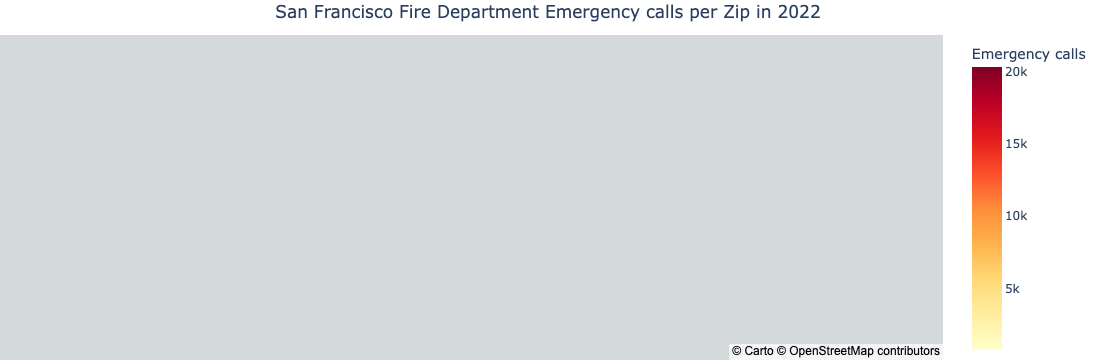

In [3]:
# group by zip and count how often the zip is in dataset, including neighborhood name (only the first time the neighborhood pops up per zip).
df_heatmap = df.groupby('zip').agg(count=('zip','size'),neighborhood=('neighborhood','first')).reset_index()

# merge the two file's
sf_map['zip'] = sf_map['zip'].astype(int)
df_heatmap['zip'] = df_heatmap['zip'].astype(int)
merged_df = pd.merge(sf_map, df_heatmap, on='zip', how='left')

# create a GeoDataFrame needed for the choropleth
gdf = gpd.GeoDataFrame(merged_df)

# plug it into the choropleth map
fig = px.choropleth_mapbox(gdf, 
                           geojson=gdf.geometry,
                           locations=gdf.index,
                           color='count',
                           color_continuous_scale="YlOrRd",
                           mapbox_style="carto-positron",
                           center={"lat": gdf.geometry.centroid.y.mean(), "lon": gdf.geometry.centroid.x.mean()},
                           zoom=10.9,
                           opacity=0.5,
                           labels={'count': ' Emergency calls'},
                           hover_data={'neighborhood': True}
                          )

fig.update_layout(title_text='San Francisco Fire Department Emergency calls per Zip in 2022',
                  title_x=0.5,
                  margin={"r":1,"t":35,"l":0,"b":0})

# adding the firestations to the map
fig.add_scattermapbox(
    lat=firestation_info['FS_latitude'],
    lon=firestation_info['FS_longitude'],
    mode='markers',
    marker=dict(
        size=5,  
        color='red',  
        opacity=0.5,
),
    text=firestation_info['Firestations'],
    name='Fire Stations',
    hoverinfo='text'
)

# displaying the choropleth map
fig.show()

# displaying the image of the SF population density aligned with the choropleth
width = 550
height = 550
left_margin = 160
image_html = f'<img src="SF_population_density.jpeg" width="{width}" height="{height}" style="display: block; margin: auto; margin-left: {left_margin}px;">'
display(HTML(image_html))

While comparing the created choropleth with the population density, it is immidiately visible that there is a relationship between the population density and the amount of emergency calls to the fire department, as one would expect *(more people, more problems)*. In addition, it is visbile that the Fire Stations are well dispersed through the city.

Some trivial information: one the darkest areas on the choropleth is the neighborhood Tenderloin. Taking its name from an older, but similar, neighborhood in New York. In 1986, a New York City newspaper published Police Department Captain Alexander S. Williams as saying: *“I’ve had nothing but chuck steak for a long time, and now I’m going to get a little of the tenderloin."* Essentially refering to idea that he could earn so much money by accepting bribes to overlook crimes that he could buy a more expensive cut of meat for his dinner. Although it is not known for sure where the name came from, the fact that the Tenderloin District has the highest rate of homelessness in SF does add some credibility to the statement, and potentially to the amount of calls that the fire department receives.

.

Again, in trying the make sense of the data we also wanted to find out when and at what time the calls took place. Therefore, we created a heatmap showing the total calls made per hour per day of the week.

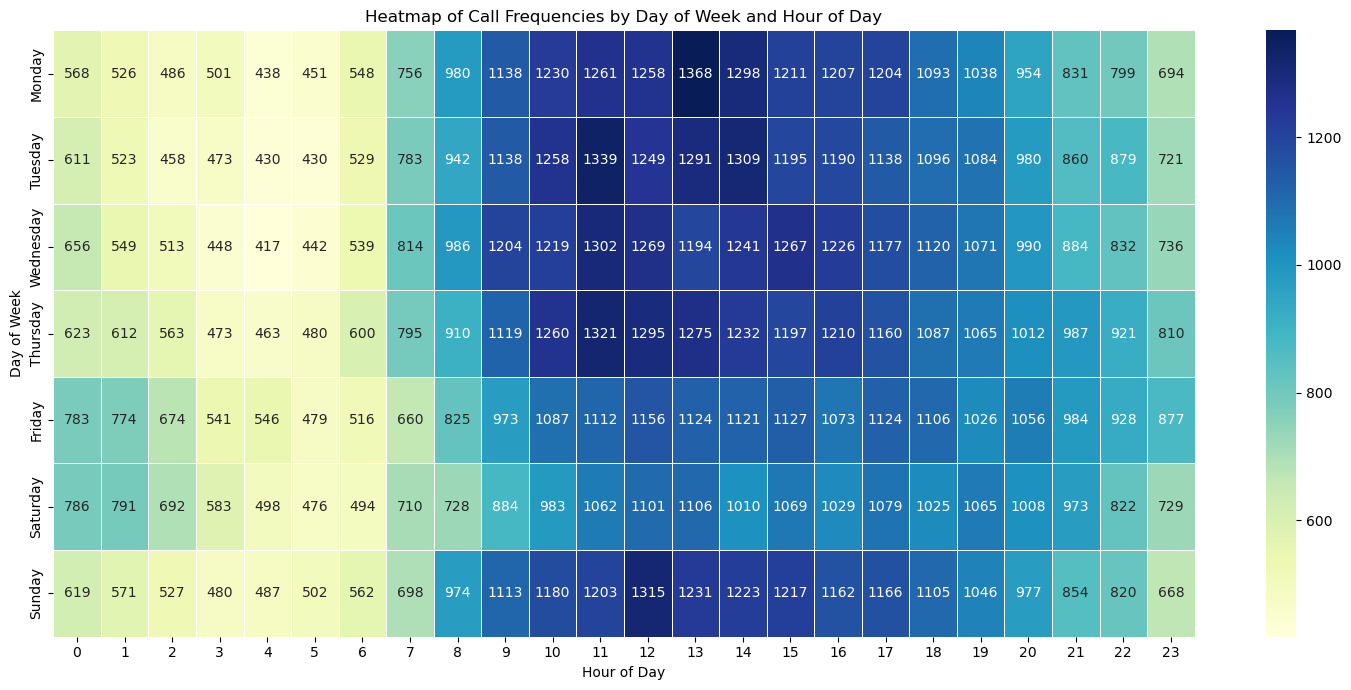

In [26]:
# mappying the correct weekday 'names'
day_of_week_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 
                       4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
df['day_of_week'] = df['day_of_week'].map(day_of_week_names)

# ordering by weekday
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=order, ordered=True)

# count per hour per day
hour_day_df = df.pivot_table(index='day_of_week', columns='hour_of_the_day', values='callnumber', aggfunc='count')

# creating heatmap 
plt.figure(figsize=(15, 7))
sns.heatmap(hour_day_df, cmap='YlGnBu', linewidths=.5, annot=True, fmt="d")
plt.title('Heatmap of Call Frequencies by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

The heatmap shows clearly that most calls happen during the day compared to the night, as what you would expect. Additionally, it highlights a noticeable increase in call volume around midnight on Fridays and Saturdays, a trend that logically coincides with people typically staying up later on these nights for activities such as parties or social gatherings. So far, no anomolies in the data...

.

Now let's have a look at our categorical variables and how they interact with the variable of interest: **response time**. To analyse this we created two plots, sitting next to each other. With the left plot visualizing the distribution of **response time** through boxplots, and the horizontal bars figure showing the frequency of the labels in the data. In addition, as this dataset contains multiple categorical variables we made it interactive, meaning that you can select which variable to display.

*(If it isn't displayed properly, please load the data at the beginning of this chapter and run the cell below)*

In [4]:
def interactive_plot(category):
    # calculating the number of calls per category value
    category_counts = df[category].value_counts()
    sorted_categories = category_counts.index.tolist()

    # creating two subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 13), gridspec_kw={'width_ratios': [2.5, 1]})

    # sorting on order of categories with descending number of calls
    df[category] = pd.Categorical(df[category], categories=sorted_categories, ordered=True)
    sorted_data = df.sort_values(by=category)

    # the plot
    sns.boxplot(x='respond_time', y=category, data=sorted_data, showfliers=False, orient='h', ax=axs[0])
    axs[0].set_title(f'Distribution of Response Time per {category.title()}')
    axs[0].set_ylabel(category.title())
    axs[0].set_xlabel('Response Time')

    # reversing the order of categories for the bar chart
    sorted_categories.reverse()

    # the bar chart
    category_counts.loc[sorted_categories].plot(kind='barh', ax=axs[1])
    axs[1].set_title(f'Number of Calls per {category.title()}')
    axs[1].set_xlabel('Number of Calls')
    axs[1].set_yticks([])

    plt.tight_layout()

# categories for dropdown
categories = ['calltype', 'calltypegroup', 'unittype', 'city','originalpriority', 'alsunit', 'battalion',
              'neighborhood', 'month', 'day_of_week', 'hour_of_the_day']
dropdown = Dropdown(options=categories)

# the interactive widget
interact(interactive_plot, category=dropdown)

plt.show()

interactive(children=(Dropdown(description='category', options=('calltype', 'calltypegroup', 'unittype', 'city…

Looking at the variables 'unittype', 'city', 'original priority', and 'alsunit' reveals distinct variations in the distribution of **response time** across their categories. Suggesting that they are good feature candidates for our model. The same can be said about the variable 'hour_of_the_day'. However, for the variables 'batallion', 'day_of_week', and 'month', the differentiation is less visible. Indicated by the close similarity in the median values and quartile ranges.

Navigate to the category: 'Calltype'. While looking at both plots, the call type 'Medical Incident', peaked our interest. Not only because the amount of calls outnumbers the other emergencies by a stretch. But more importantly, the response time is very dispersed, with a big chunk of responses taking longer than 10 minutes (>600 seconds) and that seems like an awfull long time to wait. This required some extra research (=Googling). 

First of all, why does the Fire Department even respond to medical incidents? Well, as it turns out many firemen (women) are also paramedics and, as we saw on the choroplethmap, Fire Stations are well dispersed throughout San Francisco. This means that the Fire Department is simply able to respond quicker. Furthermore, we learned that medical incidents are classified in life-threatening and not life-threatening. Meaning that the city has different policies on the response time. In the case of a life-threatening emergency, the policy states that medical care should arrive within 10 minutes 90% of the time and within 20 minutes 90% of the time for non-life threatening situations. Let's check if that's the case...


Source (medical response time SF): https://sfgov.org/scorecards/public-safety/

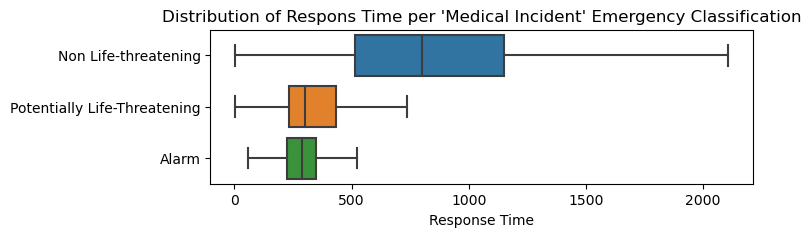

In [7]:
# selecting only the 'Medical Incident' emergencies.
df_medical = df[df['calltype'] == 'Medical Incident']

plt.figure(figsize=(7,2))
sns.boxplot(x='respond_time', y='calltypegroup', data=df_medical, showfliers=False, orient='h')
plt.title("Distribution of Respons Time per 'Medical Incident' Emergency Classification")
plt.ylabel('')
plt.xlabel('Response Time')

plt.show()

Seeing the emergency classifications and their distribution shows indeed that the response time of the Fire Department for life-threatening situations is most often within 10 minutes (< 600 seconds) and that for non life-threatening situations the respons time takes longer but mostly within the 20 minutes time frame (altough it doesn't look like they adhere to the policy of arriving 90% of the time within 20 minutes). This shows that the dispersion in 'Medical Incident' doesn't seem to unusual. Let's continue...

.

After having looked at our categorical variables, it is now time to look at the continious variables that we created *(with sweat, tears, and battery life)* and how they compare to **response time**. We will do that by simply looking at the correlation.



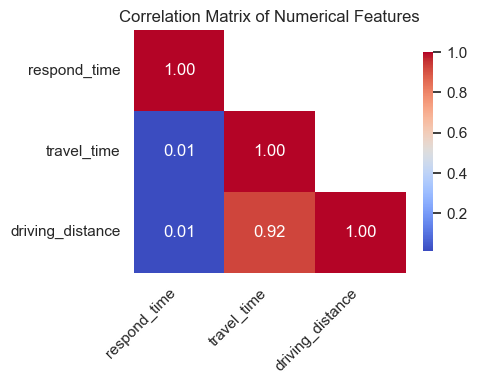

In [226]:
categories = ['respond_time', 'travel_time', 'driving_distance']
# Selecting numerical 
numerical_data = df[categories]

# correlation matrix
correlation_matrix = numerical_data.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
mask[-1, -1] = False  # reveiling the diagonal line
mask[1,1] = False
mask[0,0] = False


# creating a heatmap for the correlation matrix 
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, cbar_kws={"shrink": .82}, linewidths=0)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.grid(False)
plt.show()


The effort invested in creating the travel time and driving distance from the fire station to the incident doesn't seem justified, considering the correlation between them and the **response time** is basically 0. Nevertheless, given the computational resources dedicated to generating this information, it is reasonable to include it as a feature. It's worth noting that the driving distance and travel time are highly corelated, as one would expect. Which means that if we introduced both variables to the model we would have multicollinearity *(and we don't want that)*. Consequently, we only add driving distance as a feature.

## 3. PREDICTING

Now we arrived at the exciting part of this notebook. Where we will try to answer the question: *can we accurately predict the **response time** of the San Francisco Fire Department?* As we are dealing with a continious variable of interest and a large dataset, we will try to estimate the **response time** using the following methods: *linear regression, Random Forrest, K-Nearest Neighbor, and Gradient Boosting*. In addition, after fitting, predicting and visualizing the results we will compare the four methods by looking at the Mean Squared Error, Mean Absolute Error, and the R-squared. 

In [ ]:
['calltype','unittype','battalion','city','original priority',
 'alsunit','neighborhood','day_of_week','hour_of_the_day']

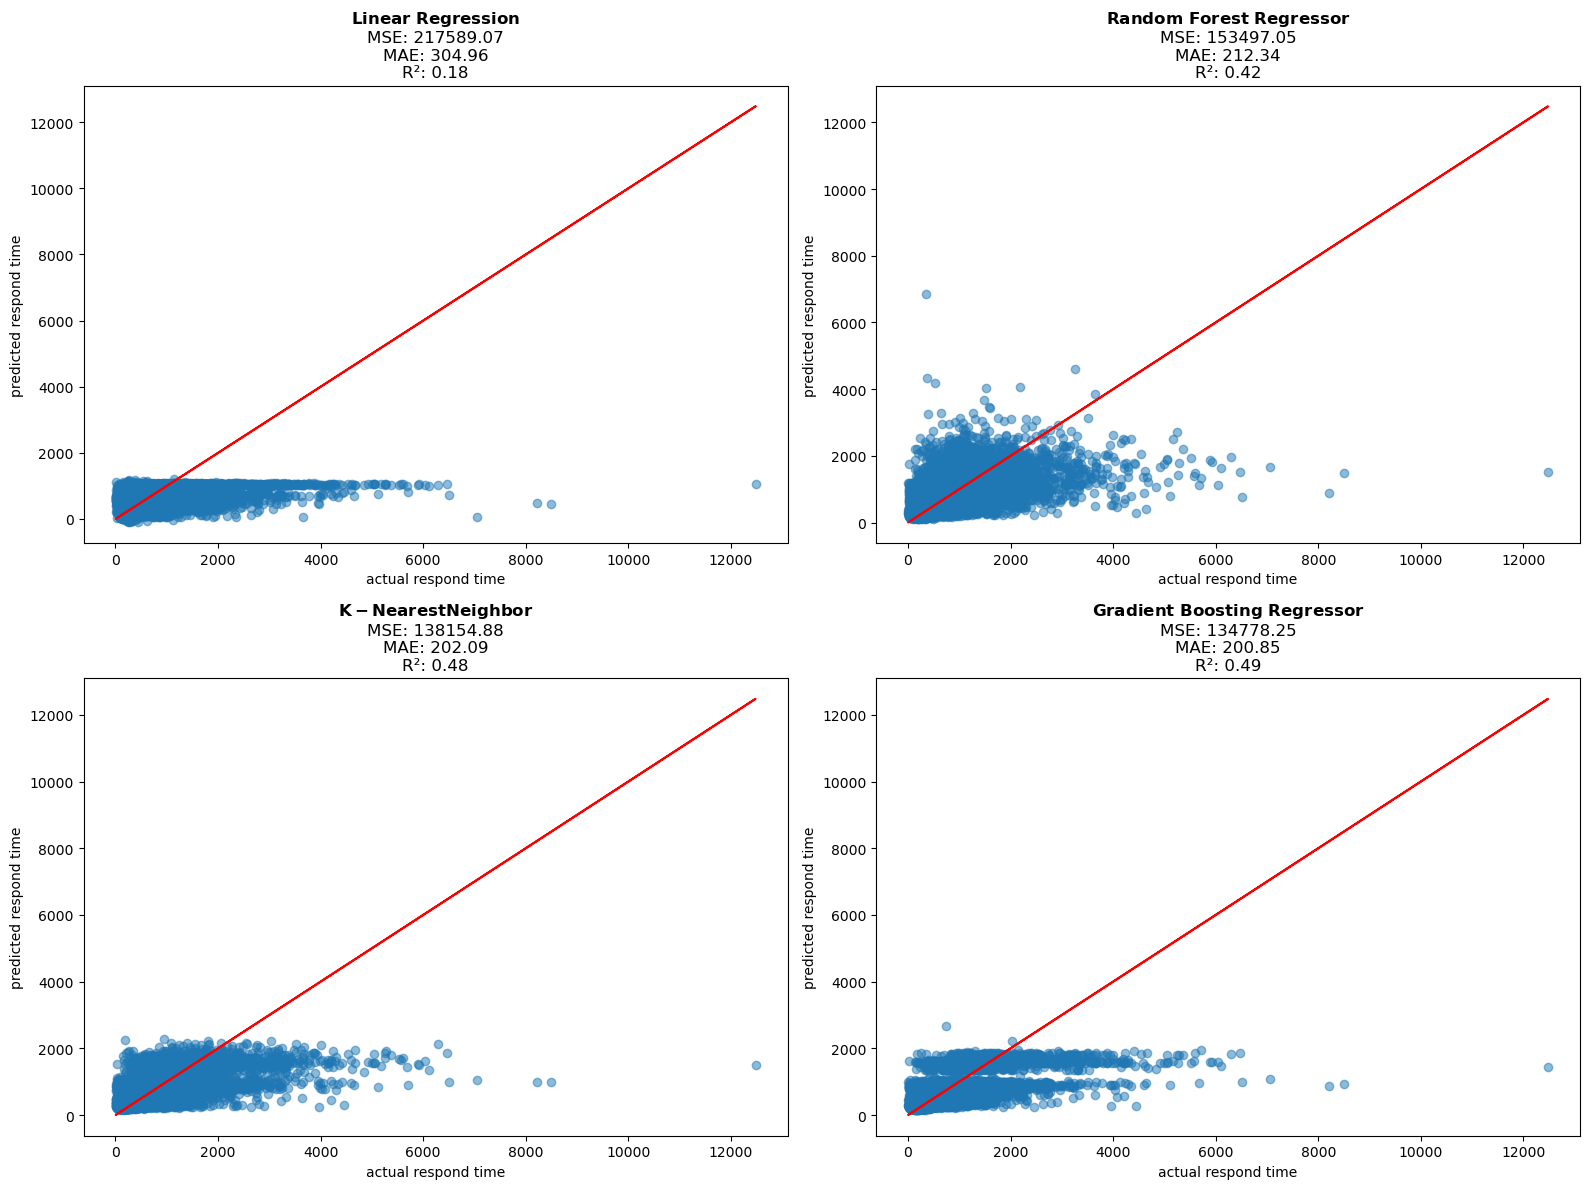

In [103]:
specified_columns = ['respond_time', 'city', 'neighborhood', 'unittype', 'originalpriority', 
                      'calltype', 'alsunit', 'hour_of_the_day', 'driving_distance',
                      'firepreventiondistrict', 'calltypegroup']

# removing outliers

df3 = df[specified_columns]
# df3 = df3[df3['calltypegroup'] != 'Non Life-threatening' ]

# Q1 = df3['respond_time'].quantile(0.25)
# Q3 = df3['respond_time'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# df3 = df3[(df3['respond_time'] >= lower_bound) & (df3['respond_time'] <= upper_bound)]


# Handling missing values and encoding categorical variables
label_encoder = LabelEncoder()
df3 = df3.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' or col.dtype.name == 'category' else col)


# Separate the features and the target variable
X = df3.drop('respond_time', axis=1)
y = df3['respond_time']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)


# training each model
lr_regressor = LinearRegression()
lr_regressor.fit(X_train, y_train)

rf_regressor = RandomForestRegressor(n_estimators=100,random_state=2)
rf_regressor.fit(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_regressor = KNeighborsRegressor(n_neighbors=50) 
knn_regressor.fit(X_train_scaled, y_train)

gb_regressor = GradientBoostingRegressor(random_state=2)
gb_regressor.fit(X_train, y_train)

# making the predictions
y_pred_linear = lr_regressor.predict(X_test)
y_pred_rf = rf_regressor.predict(X_test)
y_pred_knn = knn_regressor.predict(X_test_scaled)
y_pred_gbr = gb_regressor.predict(X_test)

# calculating metrics for the models
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

# scatterplot will be visualized on 2 rows
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Linear
axes[0, 0].scatter(y_test, y_pred_linear, alpha=0.5)
axes[0, 0].plot(y_test, y_test, color='red')  # adding a 45-degree line
axes[0, 0].set_title(f'$\\bf{{Linear\ Regression}}$\nMSE: {mse_linear:.2f}\nMAE: {mae_linear:.2f}\nR²: {r2_linear:.2f}')
axes[0, 0].set_xlabel('actual respond time')
axes[0, 0].set_ylabel('predicted respond time')

# Random Forest
axes[0, 1].scatter(y_test, y_pred_rf, alpha=0.5)
axes[0, 1].plot(y_test, y_test, color='red') 
axes[0, 1].set_title(f'$\\bf{{Random\ Forest\ Regressor}}$\nMSE: {mse_rf:.2f}\nMAE: {mae_rf:.2f}\nR²: {r2_rf:.2f}')
axes[0, 1].set_xlabel('actual respond time')
axes[0, 1].set_ylabel('predicted respond time')

# KNN
axes[1, 0].scatter(y_test, y_pred_knn, alpha=0.5)
axes[1, 0].plot(y_test, y_test, color='red') 
axes[1, 0].set_title(f'$\\bf{{K-Nearest Neighbor}}$\nMSE: {mse_knn:.2f}\nMAE: {mae_knn:.2f}\nR²: {r2_knn:.2f}')
axes[1, 0].set_xlabel('actual respond time')
axes[1, 0].set_ylabel('predicted respond time')

# Gradient Boosting
axes[1, 1].scatter(y_test, y_pred_gbr, alpha=0.5)
axes[1, 1].plot(y_test, y_test, color='red')
axes[1, 1].set_title(f'$\\bf{{Gradient\ Boosting\ Regressor}}$\nMSE: {mse_gbr:.2f}\nMAE: {mae_gbr:.2f}\nR²: {r2_gbr:.2f}')
axes[1, 1].set_xlabel('actual respond time')
axes[1, 1].set_ylabel('predicted respond time')

plt.tight_layout()
plt.show()

In each plot, the points represent actual vs. predicted values. The closer these points are to the red line *(which represents a perfect prediction)*, the better the model's predictions. Unfortunately, it looks like all models have difficulty with accurately predicting higher response times, as indicated by the spread of points that deviate from the line as the actual respond time increases. In addition, with the lowest Mean Absolute Error being 201 seconds the results are quite disapointing. Meaning that the model's prediction *(i.e., Gradient Boosting)* is on average 201 seconds away from the truth... 

However, we are not giving up yet! We could try to exclude outliers, but it might be so that predicting response time to the second is just too difficult with this data. So, instead of predicting the response time to the second, let's try and predict it to the minute. In this way, operators could still give some indication of how quick the fire department will be there. Moreover, instead of running the entire dataset we will focus on emergencies that are not life-threatening. This approach prioritizes callers for whom estimating the arrival time provides the most significant benefit.

We categorized the variable of interest **response time** into categories of 60 seconds *(e.g., a response time of 1min and 3sec, would be categorized as 120 seconds, etc)*. Unfortunately, this conversion still resulted in a lot of categories. Therefore, with one of the goals of this course being to visualize data, we decided to show only the first 20 intervals in the Confusion Matrix *(the displayed accuracy still represents the overal accuracy of the model)*. Lastly, with our variable of interest being changed from continious to categorical we will be using the following methods to determine **response time**: *Random Forest, Support Vector Machine with Radial Basis Function, K-Nearest Neighbors, and AdaBoost*.

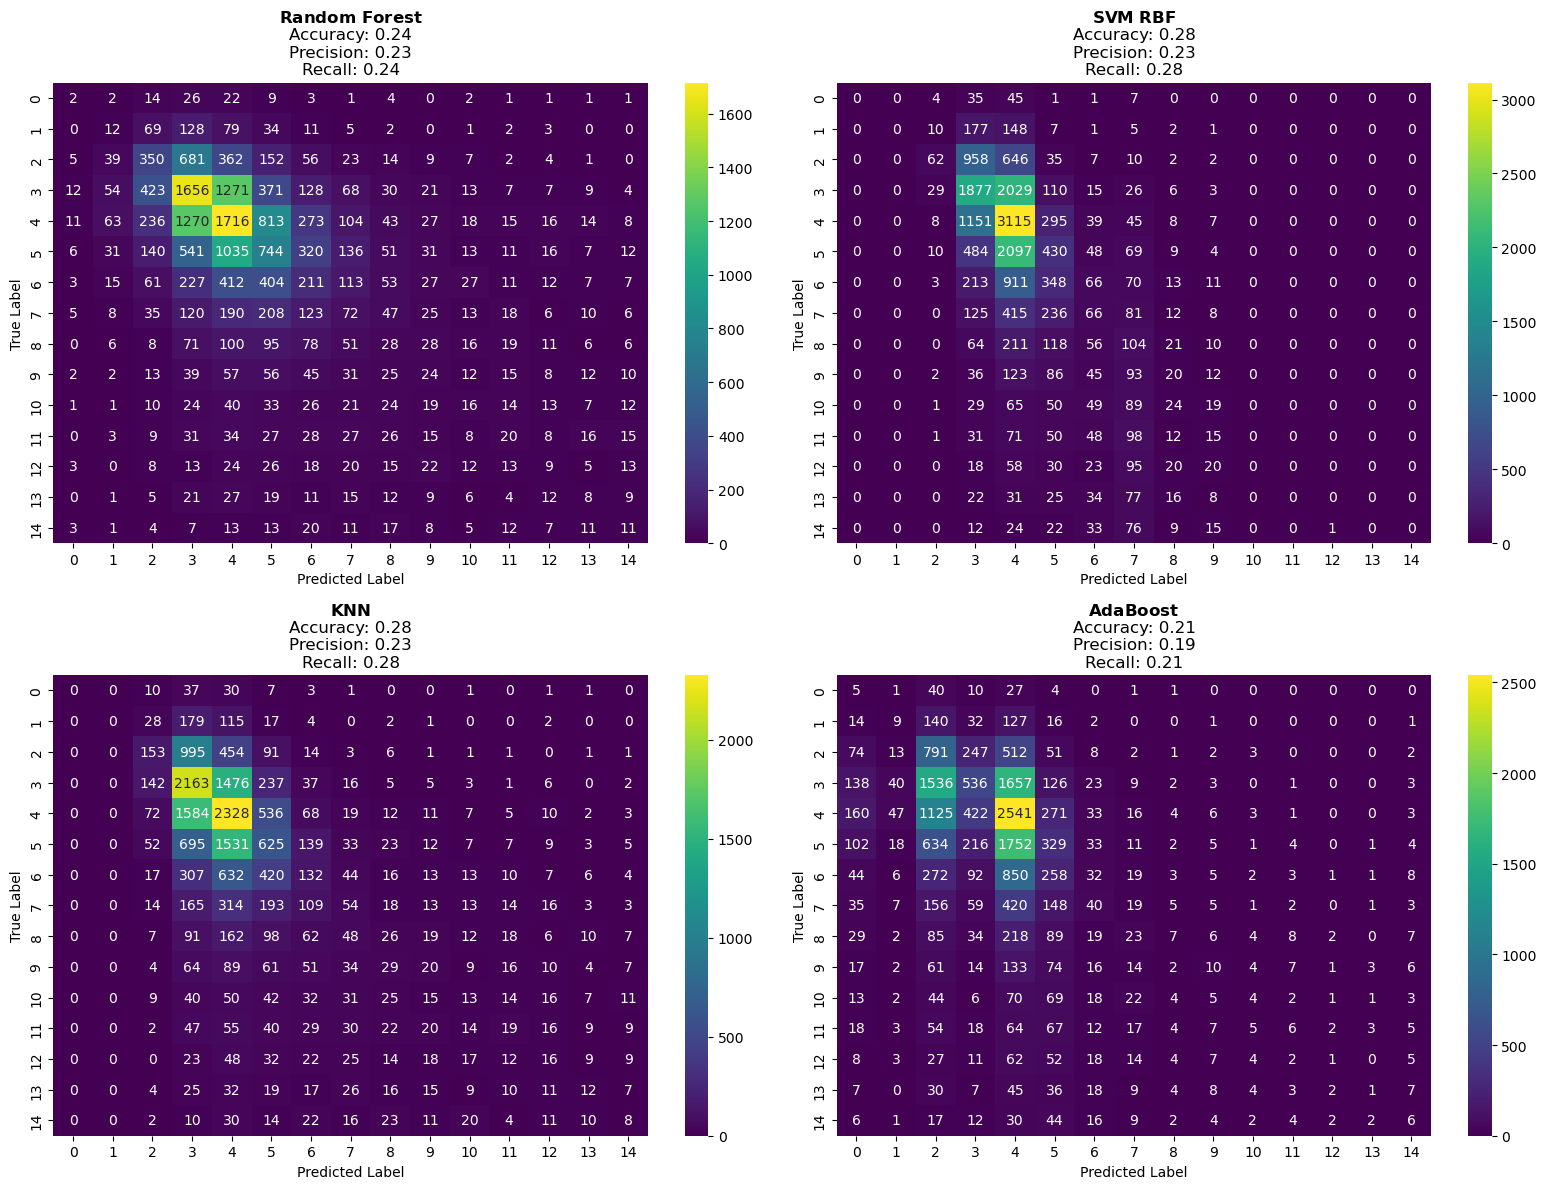

In [117]:
specified_columns = ['respond_time', 'city', 'neighborhood', 'unittype', 'originalpriority', 
                      'calltype', 'alsunit', 'hour_of_the_day', 'driving_distance',
                      'firepreventiondistrict', 'calltypegroup']


df6 = df[df['calltypegroup'] != 'Non Life-threatening' ]
df6 = df6[specified_columns]

# encoding categorical variables
label_encoder = LabelEncoder()
df6 = df6.apply(lambda col: label_encoder.fit_transform(col) if col.dtype == 'object' or col.dtype.name == 'category' else col)

# categorizing 'respond_time' using 60-second intervals
df6['respond_time_cat'] = (df6['respond_time'] // 60 + 1) * 60

# separating feautures and target
X = df6.drop(columns=['respond_time','respond_time_cat'], axis=1)
y = df6['respond_time_cat']

# splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Random Forest
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred_RFC = clf.predict(X_test)

rfc_accuracy = accuracy_score(y_test, y_pred_RFC)
rfc_precision = precision_score(y_test, y_pred_RFC, average='weighted')
rfc_recall = recall_score(y_test, y_pred_RFC, average='weighted')

# RBF SVM 
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
pipeline.fit(X_train, y_train)
y_pred_RBF = pipeline.predict(X_test)

RBF_accuracy = accuracy_score(y_test, y_pred_RBF)
RBF_precision = precision_score(y_test, y_pred_RBF, average='weighted')
RBF_recall = recall_score(y_test, y_pred_RBF, average='weighted')

# KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_classifier = KNeighborsClassifier(n_neighbors=50)  
knn_classifier.fit(X_train_scaled, y_train)
y_pred_KNN = knn_classifier.predict(X_test_scaled)

KNN_accuracy = accuracy_score(y_test, y_pred_KNN)
KNN_precision = precision_score(y_test, y_pred_KNN, average='weighted')
KNN_recall = recall_score(y_test, y_pred_KNN, average='weighted')


# AdaBoost
base_estimator = DecisionTreeClassifier(max_depth=6)
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, learning_rate=1.0)
ada_boost.fit(X_train, y_train)
y_pred_ADA = ada_boost.predict(X_test)
ada_accuracy = accuracy_score(y_test, y_pred_ADA)

ada_precision = precision_score(y_test, y_pred_ADA, average='weighted')
ada_recall = recall_score(y_test, y_pred_ADA, average='weighted')

# computing confusion matrices
cm_RFC = confusion_matrix(y_test, y_pred_RFC)
cm_RBF = confusion_matrix(y_test, y_pred_RBF)
cm_KNN = confusion_matrix(y_test, y_pred_KNN)
cm_ADA = confusion_matrix(y_test, y_pred_ADA)


# only visualizing the first 15 rows
cm_RFC_sliced = cm_RFC[:15, :15]
cm_RBF_sliced = cm_RBF[:15, :15]
cm_KNN_sliced = cm_KNN[:15, :15]
cm_ADA_sliced = cm_ADA[:15, :15]

# creating 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix Random Forest
sns.heatmap(cm_RFC_sliced, annot=True, fmt="d", cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title(f'$\\bf{{Random\ Forest}}$\nAccuracy: {rfc_accuracy:.2f}\nPrecision: {rfc_precision:.2f}\nRecall: {rfc_recall:.2f}')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Confusion Matrix Logistic RBF
sns.heatmap(cm_RBF_sliced, annot=True, fmt="d", cmap='viridis', ax=axes[0, 1])
axes[0, 1].set_title(f'$\\bf{{SVM\ RBF}}$\nAccuracy: {RBF_accuracy:.2f}\nPrecision: {RBF_precision:.2f}\nRecall: {RBF_recall:.2f}')
axes[0, 1].set_ylabel('True Label')
axes[0, 1].set_xlabel('Predicted Label')

# Confusion Matrix for KNN
sns.heatmap(cm_KNN_sliced, annot=True, fmt="d", cmap='viridis', ax=axes[1, 0])
axes[1, 0].set_title(f'$\\bf{{KNN}}$\nAccuracy: {KNN_accuracy:.2f}\nPrecision: {KNN_precision:.2f}\nRecall: {KNN_recall:.2f}')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Confusion Matrix for AdaBoost
sns.heatmap(cm_ADA_sliced, annot=True, fmt="g",cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title(f'$\\bf{{AdaBoost}}$\nAccuracy: {ada_accuracy:.2f}\nPrecision: {ada_precision:.2f}\nRecall: {ada_recall:.2f}')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

All models have some concentration of values along the diagonal, which is good. However, the spread of values off the diagonal suggests that each model is often confused, particularly between intervals that are adjacent to each other. Which makes sense, considering that we categorized values of 123 seconds to 180 and 119 seconds to 120. Moreover, although the performance metrics are more or less consistent across the models, they do indicate that the models struggles heavily with classifying the **response time**. 

It doesn't seems like categorizing **response time** was much of an improvement :(

# CONCLUSION

At the beginning of this notebook we set out to predict the **response time** of the San Francisco Fire Department. To do that properly, we first cleaned the data, added additional features and downloaded/webscraped some extra information. This allowed us to get a good understanding of our data and select the features we would use to eventually predict the **response time**. 

Unfortunately, we have to conclude that *(based on the information in this dataset, the features we added, and our current knowledge of Machine Learning)* we weren't able to develop an accurate predictive model on the **response time** of the San Francisco Fire Department... It could be that there are other factors not captured in the dataset influencing the **response time**, or that there is a need for more complex modeling techniques and hyperparameter tuning. Or maybe, the **response time** is simply too random to predict and people should be satisfied by just knowing that the Fire Department is on its way...